# Hypothesis 2: Negative Reviews Are Longer

## Load the data

In [ ]:
#Importing Needed Libraries
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import scipy.stats as stats
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /home/ds/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Connect to MongoDB and select the database
mongo = pymongo.MongoClient()
mongo_db = mongo.project
# Load the reviews from the reviews collection
data = pd.DataFrame(list(mongo_db.reviews.find({}, {'_id': False})))
#Close the connection
mongo.close()
print(data.shape)

(300639, 11)


## Start the investigation

In [ ]:
#Preparing Data To Ivestigate The Hypothesis

sub_data = pd.DataFrame()
sub_data['movie'] = data['movie']
sub_data['review'] = data['review_detail']
sub_data['rev_length'] = data['review_detail'].apply(len)

sub_data.head()

,movie,review,rev_length
0,Satanic (2016),"Seriously, don't waste yout time, this is a pr...",180
1,Satanic (2016),Dropped out 20 mins in... characters were tota...,407
2,Satanic (2016),Seeing the ratings on IMDb I wondered why the ...,678
3,Satanic (2016),"I only did that because 1 is the lowest point,...",1134
4,Satanic Meat Cleaver Massacre (2017),SATANIC MEAT CLEAVER MASSACRE is a dreadful in...,416


### Sentiment with VADER

In [ ]:
#Perform Sentiment Analysis To Classify Reviews To Positive And Negative using VADER

sid = SentimentIntensityAnalyzer()

#Apply sentiment analysis using VADER and extract the compound score
#Assign a binary sentiment label (1 for positive, 0 for negative)
def classify_sentiment_v(review):
    sentiment_scores = sid.polarity_scores(review)
    if sentiment_scores['compound'] >= 0:
        return 1  # Positive review
    else:
        return 0  # Negative review

#Add the sentiment labels to the dataset or perform further processing as needed
sub_data['sentiment'] = sub_data['review'].apply(classify_sentiment_v)

sub_data.head()

,movie,review,rev_length,sentiment
0,Satanic (2016),"Seriously, don't waste yout time, this is a pr...",180,1
1,Satanic (2016),Dropped out 20 mins in... characters were tota...,407,0
2,Satanic (2016),Seeing the ratings on IMDb I wondered why the ...,678,1
3,Satanic (2016),"I only did that because 1 is the lowest point,...",1134,0
4,Satanic Meat Cleaver Massacre (2017),SATANIC MEAT CLEAVER MASSACRE is a dreadful in...,416,0


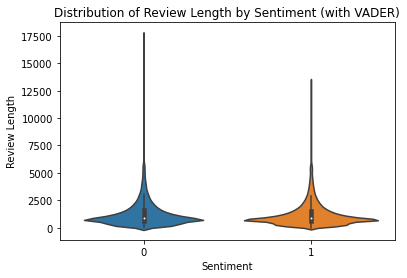

In [ ]:
sns.violinplot(x='sentiment', y='rev_length', data=sub_data)

# Set labels and title
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.title('Distribution of Review Length by Sentiment (with VADER)')

# Show the plot
plt.show()

t-statistic:	 11.191235635929605 
p-value:	 4.561195219581046e-29


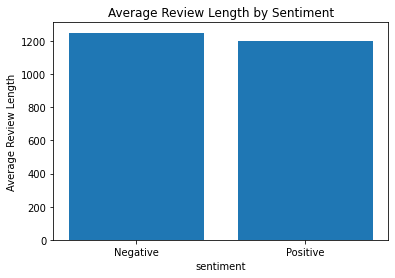

In [ ]:
#Apply Statistics To Falsify The Hypothesis

#Separate the lengths of negative and positive reviews
#loc used for conditional filtering
negative_lengths = sub_data.loc[sub_data['sentiment'] == 0, 'rev_length']
positive_lengths = sub_data.loc[sub_data['sentiment'] == 1, 'rev_length']

# Perform an independent t-test to compare the means of the two groups
t_statistic, p_value = stats.ttest_ind(negative_lengths, positive_lengths)

print("t-statistic:\t",t_statistic,"\np-value:\t",p_value)

# Create a bar plot
plt.bar(['Negative', 'Positive'], [negative_lengths.mean(), positive_lengths.mean()])
plt.xlabel('sentiment')
plt.ylabel('Average Review Length')
plt.title('Average Review Length by Sentiment')
plt.show()

#### As the p-value is really small we can say that there is a statistically significant difference in the lengths of negative and positive reviews. However, the size of the effect is so small that it's not useful in practice.

### Sentiment with TextBlob

In [ ]:
#Apply sentiment analysis using TextBlob for Comparison
#Assign a binary sentiment label (1 for positive, 0 for negative)

def classify_sentiment_tb(review):
    blob = TextBlob(review)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        return 1  # Positive review
    else:
        return 0  # Negative review

#Add the sentiment labels to the dataset or perform further processing as needed
sub_data['sentiment_tb'] = sub_data['review'].apply(classify_sentiment_tb)

sub_data.head()

,movie,review,rev_length,sentiment,sentiment_tb
0,Satanic (2016),"Seriously, don't waste yout time, this is a pr...",180,1,0
1,Satanic (2016),Dropped out 20 mins in... characters were tota...,407,0,1
2,Satanic (2016),Seeing the ratings on IMDb I wondered why the ...,678,1,1
3,Satanic (2016),"I only did that because 1 is the lowest point,...",1134,0,0
4,Satanic Meat Cleaver Massacre (2017),SATANIC MEAT CLEAVER MASSACRE is a dreadful in...,416,0,0


t-statistic:	 -62.747407173992826 
p-value:	 0.0


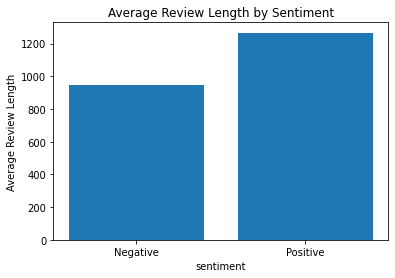

In [ ]:
#Apply Statistics To Falsify The Hypothesis

#Separate the lengths of negative and positive reviews
negative_lengths_tb = sub_data.loc[sub_data['sentiment_tb'] == 0, 'rev_length']
positive_lengths_tb = sub_data.loc[sub_data['sentiment_tb'] == 1, 'rev_length']

# Perform an independent t-test to compare the means of the two groups
t_statistic, p_value = stats.ttest_ind(negative_lengths_tb, positive_lengths_tb)

print("t-statistic:\t",t_statistic,"\np-value:\t",p_value)


# Create a bar plot
plt.bar(['Negative', 'Positive'], [negative_lengths_tb.mean(), positive_lengths_tb.mean()])
plt.xlabel('sentiment')
plt.ylabel('Average Review Length')
plt.title('Average Review Length by Sentiment')
plt.show()

#### Also in this case, the p-value suggests a statistically significant difference in the mean values, but the difference in value is aroud 20% so it could be a  more useful result. However, in this case the t-statistic has a negative sign, revealing an inverse relationship with respect to the VADER sentiment. This goes to show how impactful the choice of the model is.

### Verify the difference in calssification with the two models

In [ ]:
count_different = len(sub_data[sub_data['sentiment'] != sub_data['sentiment_tb']])
print("Number of rows where VADER and TextBlob classification are different:", count_different)


Number of rows where VADER and TextBlob classification are different: 57731


In [ ]:
test_df = sub_data.drop(sub_data[sub_data['sentiment'] != sub_data['sentiment_tb']].index)
len(test_df)

242908